## DATAREACH Multivariate Time Series Analysis

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(color_codes=True)

In [143]:
df = pd.read_csv("WHOTotConcat (1).csv", index_col=0)

In [144]:
df['Region'] = df['V2']
df['District'] = df['V3']
df = df.drop(['V2', 'V3'], axis=1)

In [145]:
df.shape

(199, 146)

In [146]:
district = df['District'].values
#df2 is the dataframe of just numbers and weeks without the district and region names
df2 = (df.drop(['Region', 'District'], axis=1))
people = df2.values

## Correlation Matrix

In [147]:
corrDf = pd.DataFrame()

In [148]:
for d, pc in zip(district, df2.values):
    corrDf[d] = pc

In [149]:
corrDf.head(10)

,BANKIM,BANYO,DJOHONG,MEIGANGA,NGAOUNDAL,NGAOUNDERE RURAL,NGAOUNDERE URBAIN,TIBATI,TIGNERE,Total ADAMAOUA,...,LIMBE,MAMFE,MBONGE,MUNDEMBA,MUYUKA,NGUTI,TIKO,TOMBEL,WABANE,Total SUD OUEST
0,6,31,7,2,4,0,0,8,20,78,...,14,18,0,1,0,3,9,1,2,111
1,8,14,7,14,0,0,0,12,26,81,...,28,17,4,0,1,3,11,1,1,171
2,11,14,5,3,0,17,1,13,17,81,...,60,9,5,2,2,4,18,0,0,186
3,0,10,1,3,0,5,5,8,16,48,...,75,16,3,1,9,4,23,0,1,220
4,10,32,5,0,0,3,7,20,6,83,...,46,20,0,3,7,4,17,0,2,234
5,13,21,1,24,0,0,0,15,23,97,...,39,24,0,1,2,3,0,0,0,234
6,9,20,2,0,0,7,6,19,28,91,...,24,26,7,7,0,12,5,0,2,199
7,22,30,16,0,0,1,4,8,56,137,...,34,23,2,0,5,1,10,0,1,199
8,11,29,1,4,16,2,0,1,35,99,...,61,39,2,1,2,1,8,0,0,173
9,34,1,0,0,0,2,0,1,3,41,...,50,11,4,1,1,4,8,3,2,136


In [150]:
corr = corrDf.corr()

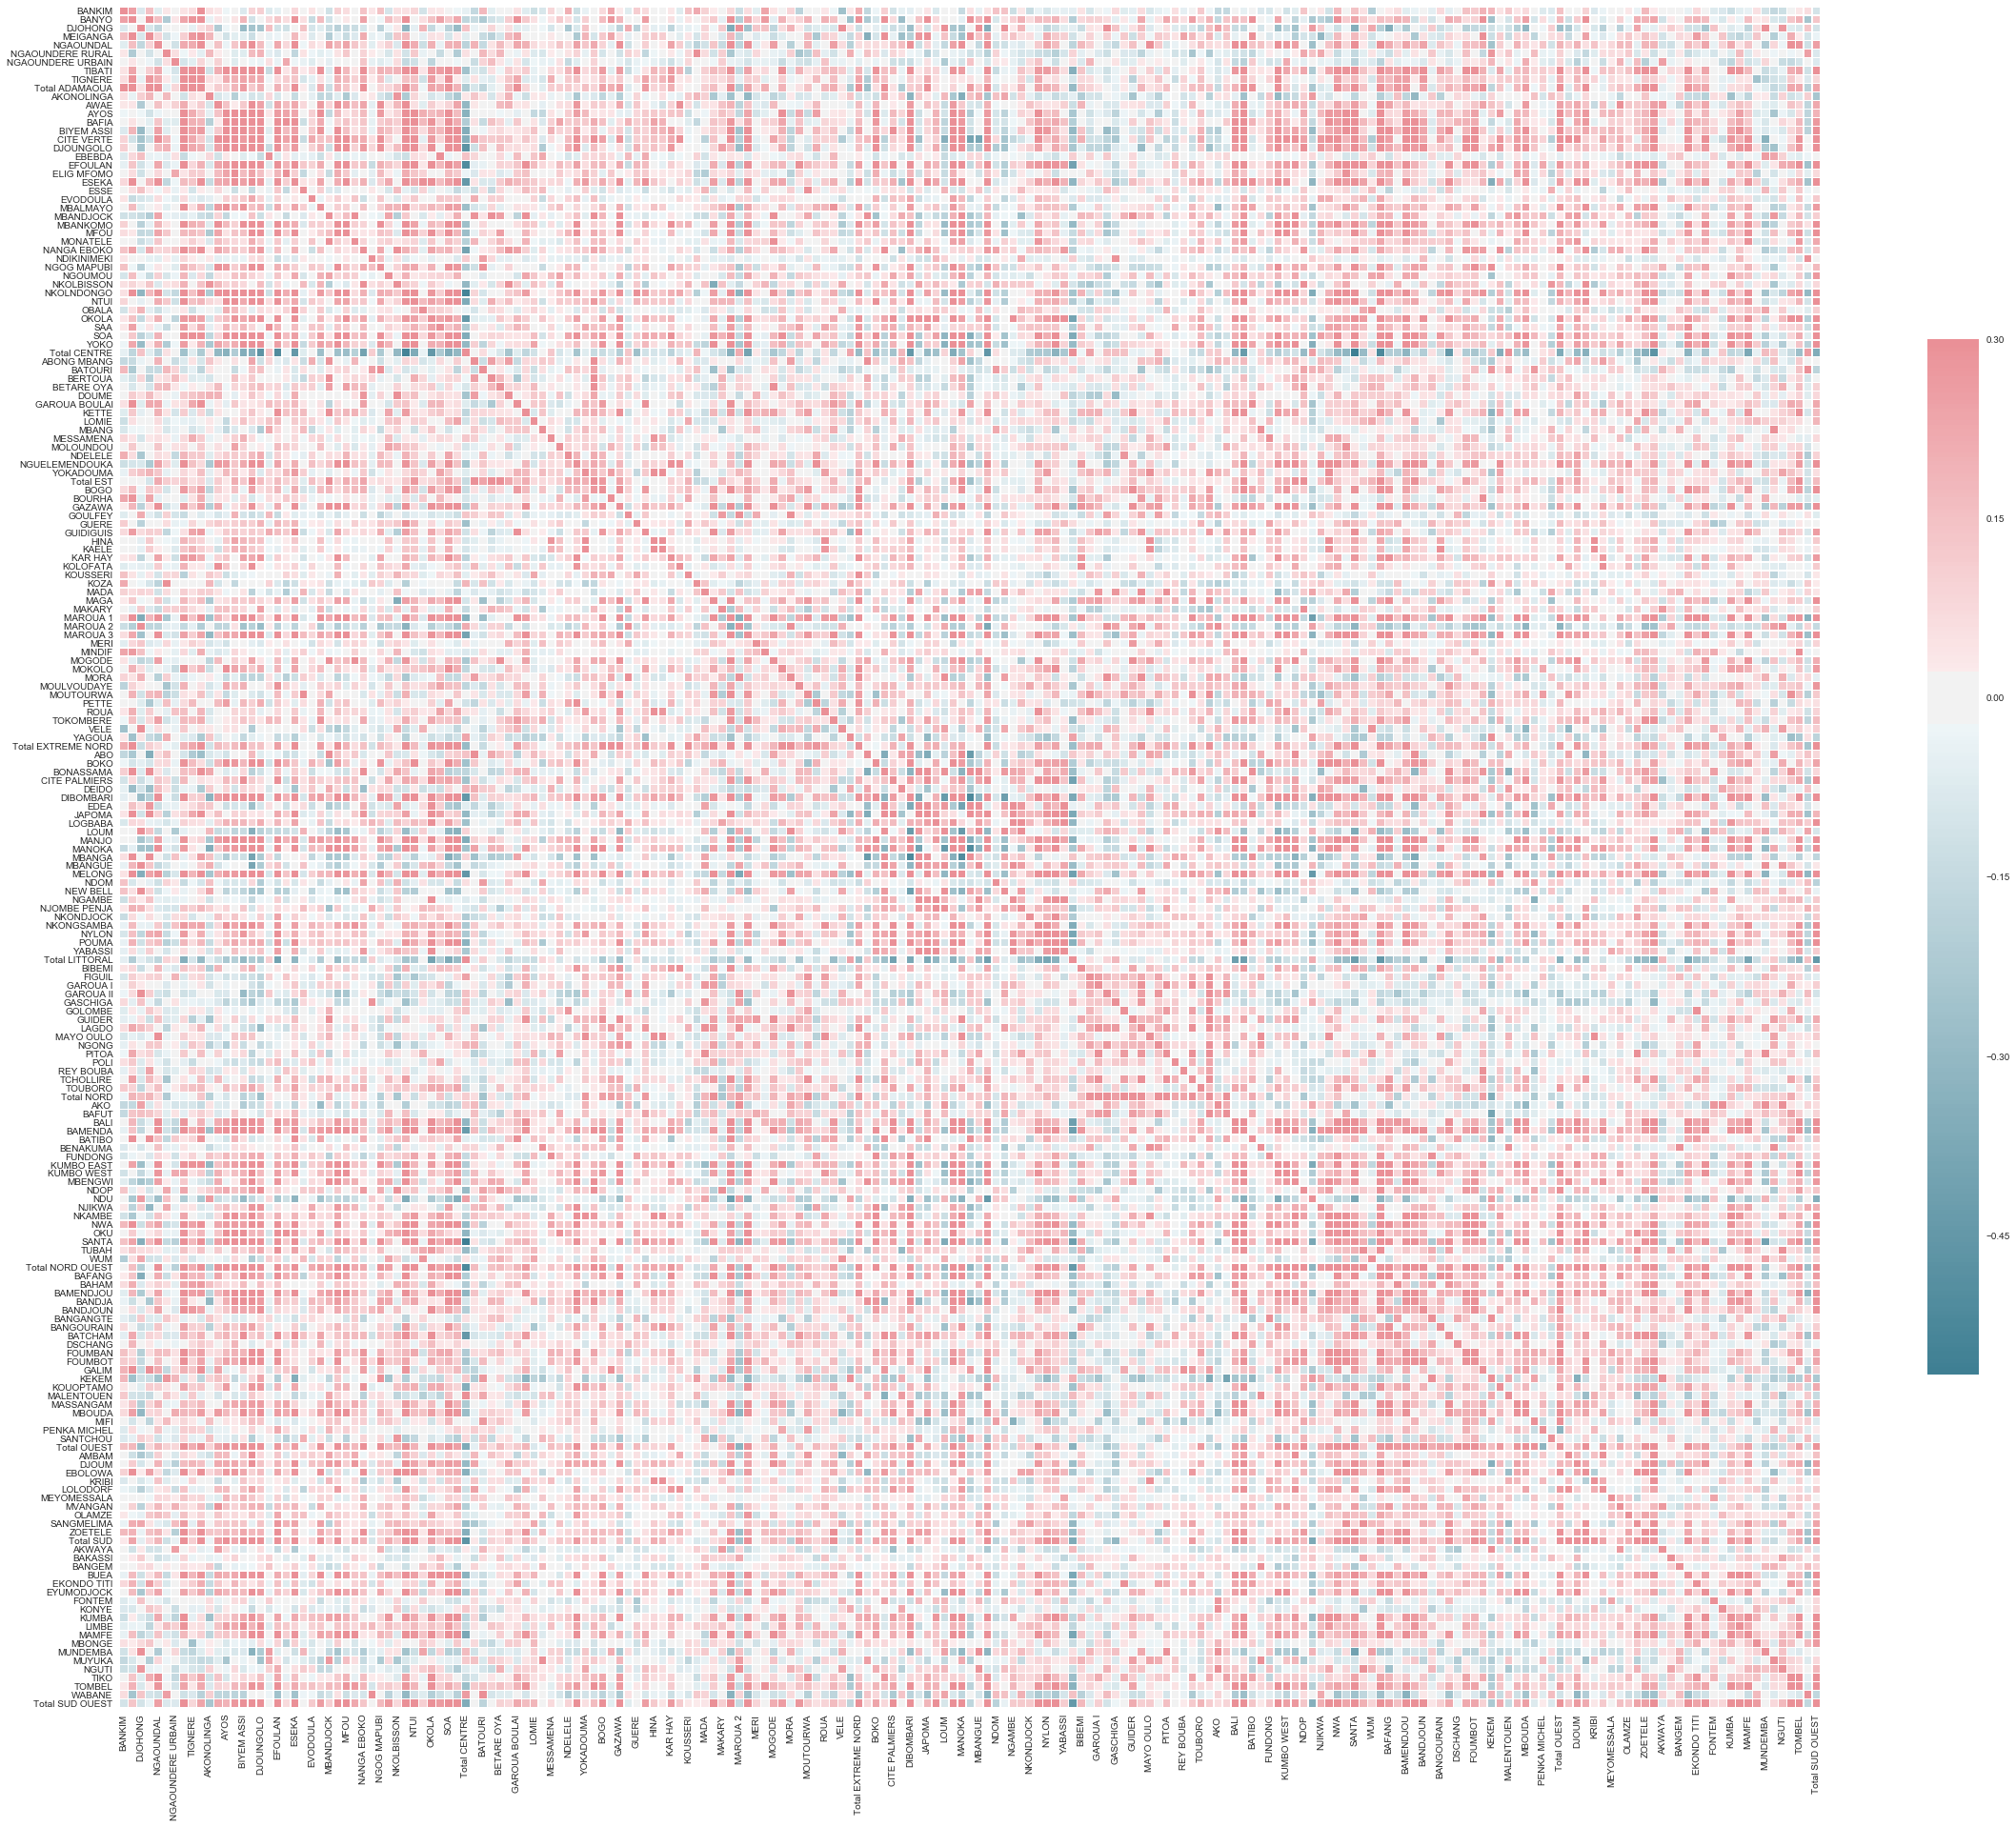

In [151]:

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 40))

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [152]:
T = 0.75
print ("T = %0.2f" % T)

T = 0.75


In [153]:
#T is the minimum threshold to show the correlation below
def printCorrelatedDistricts(T=0.75):
    global corr
    corrval = corr.values
    for i in range(0, corrval.shape[0]):
        for j in range(0, i):
            if corrval[i, j] > T:
                print ("%s , %s => %0.2f" % (district[i], district[j], corrval[i, j]))

In [154]:
printCorrelatedDistricts(T=0.6)

Total ADAMAOUA , BANYO => 0.82
Total EST , BERTOUA => 0.78
KAELE , HINA => 0.93
MOGODE , MBANDJOCK => 0.67
DIBOMBARI , CITE VERTE => 0.71
DIBOMBARI , SOA => 0.72
DIBOMBARI , YOKO => 0.69
MANJO , DIBOMBARI => 0.68
MANOKA , DIBOMBARI => 0.76
MELONG , NKOLNDONGO => 0.63
MELONG , MAROUA 1 => 0.63
MELONG , DIBOMBARI => 0.64
MAYO OULO , HINA => 0.68
MAYO OULO , KAELE => 0.66
Total NORD , GAROUA I => 0.63
BAMENDA , DIBOMBARI => 0.72
KUMBO EAST , DIBOMBARI => 0.60
KUMBO EAST , MELONG => 0.61
SANTA , NKOLNDONGO => 0.65
SANTA , YOKO => 0.65
SANTA , DIBOMBARI => 0.74
SANTA , MELONG => 0.79
SANTA , BAMENDA => 0.65
Total NORD OUEST , CITE VERTE => 0.65
Total NORD OUEST , DIBOMBARI => 0.78
Total NORD OUEST , MANOKA => 0.61
Total NORD OUEST , MELONG => 0.64
Total NORD OUEST , BAMENDA => 0.92
Total NORD OUEST , KUMBO EAST => 0.61
Total NORD OUEST , SANTA => 0.74
BAMENDJOU , Total NORD OUEST => 0.60
Total SUD OUEST , BAMENDA => 0.62
Total SUD OUEST , Total NORD OUEST => 0.62
Total SUD OUEST , BUEA => 0

## LSTM

In [155]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.core import Activation
import tensorflow as tf

In [156]:
#source:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [157]:
import math
from sklearn.preprocessing import StandardScaler

# sources: 
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# transform the dataset to a supervised dataset

def model(df,primaryDistrict, relatedDistricts, lookback=1, 
    epochs=100, verbose=0, test=0.3):
    
    c1 = df[primaryDistrict].values
    c2 = df[relatedDistricts].values
    c3 = np.column_stack((c1, c2))
    
    _df = series_to_supervised(c3, lookback)
    ntrain = math.ceil(_df.shape[0] * (1-test))

    # split into train and test sets
    values = _df.values    
    # drop last len(relatedDistricts) coloumns
    values = values[:, :-1 * (len(relatedDistricts))]
    
    #exclude last value for prediction
    X, Y = values[:, :-1], values[:, -1]
    
    # split into input and outputs
    train_X, train_y = X[:ntrain, :], Y[:ntrain]
    test_X, test_y = X[ntrain:, :], Y[ntrain:]
    
    # add extra dimensions so dimensions match for input
    train_y = np.expand_dims(train_y,axis=1)
    test_y = np.expand_dims(test_y,axis=1)
    
    # standardize values
    xscaler = StandardScaler()   
    train_X = xscaler.fit_transform(train_X)
    test_X = xscaler.transform(test_X)

    yscaler = StandardScaler()
    train_y = yscaler.fit_transform(train_y)
    test_y = yscaler.transform(test_y)
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print ("shapes")
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    print ("training LSTM network")
    with tf.device('/cpu:0'):
        model = Sequential()
        layers = [1, 50, 100, 1]
        model.add(LSTM(
                layers[1],
                input_shape=(train_X.shape[1], train_X.shape[2]),
                return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(
                layers[2],
                return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(
                layers[3]))
        model.add(Activation("linear"))
        model.compile(loss='mae', optimizer='adam')
        print (model.summary())

        # fit network
        history = model.fit(train_X, train_y, epochs=epochs,
                            batch_size=72, validation_data=(test_X, test_y),
                            verbose=verbose, shuffle=False)

        # plot history of network
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

        # make a prediction
        yhat = model.predict(test_X)

        yhat = yscaler.inverse_transform(yhat[:,0])
        print ("Root Mean Squared Error: %0.3f" % (
            mean_squared_error(_df['var1(t)'].values[-yhat.shape[0]:], yhat)))
    #     print (yhat)
        # test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

        __df = pd.DataFrame()
        __df['Actual'] = _df['var1(t)']
        __df['PeopleCountPredicted_Test'] = None
        __df['PeopleCountPredicted_Train'] = None

        print ()

        predicted = np.empty((1, __df.shape[0]))
        predicted[0,:] = None 
        predicted[0][ntrain:] = yhat

        predicted_train = np.empty((1, __df.shape[0]))
        predicted_train[0,:ntrain] = yscaler.inverse_transform(model.predict(train_X)[:,0])
        predicted_train[0][ntrain:] = None

        __df['PeopleCountPredicted_Test'] = predicted[0]
        __df['PeopleCountPredicted_Train'] = predicted_train[0]

        __df.plot(figsize=(15 ,10))

shapes
(100, 1, 6) (100, 1) (42, 1, 6) (42, 1)
training LSTM network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 1, 50)             11400     
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_38 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_19 (Activation)   (None, 1)                 0         
Total params: 71,901
Trainable params: 71,901
Non-trainable params: 0
___

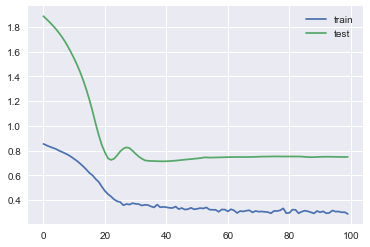

Root Mean Squared Error: 1499.261



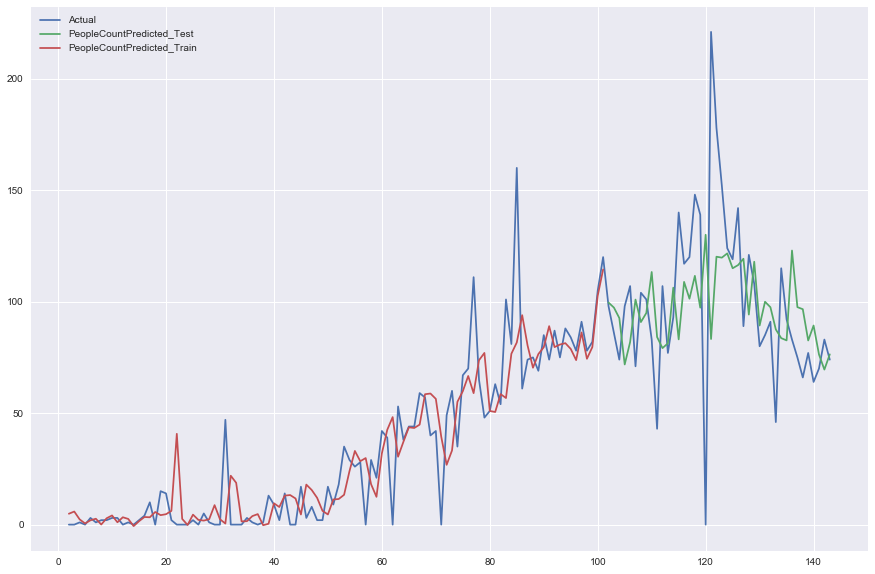

In [158]:
model(corrDf, 'MELONG', ['KUMBO EAST', 'BAMENDA'], lookback=2)

shapes
(87, 1, 60) (87, 1) (37, 1, 60) (37, 1)
training LSTM network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 1, 50)             22200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
Total params: 82,701
Trainable params: 82,701
Non-trainable params: 0
___

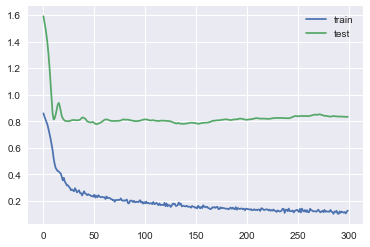

Root Mean Squared Error: 1679.812



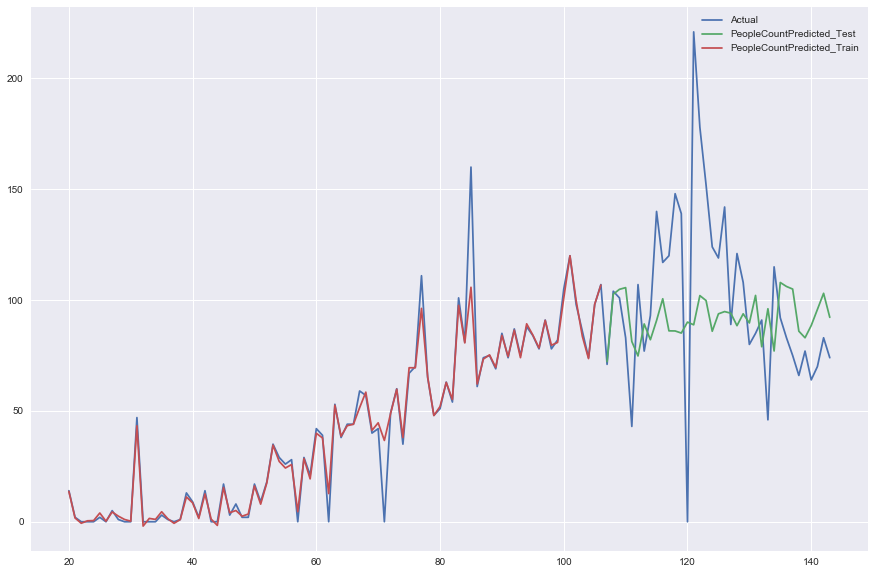

In [159]:
model(corrDf, 'MELONG', ['KUMBO EAST', 'BAMENDA'], lookback=20, epochs=300)

## Adding more Districts

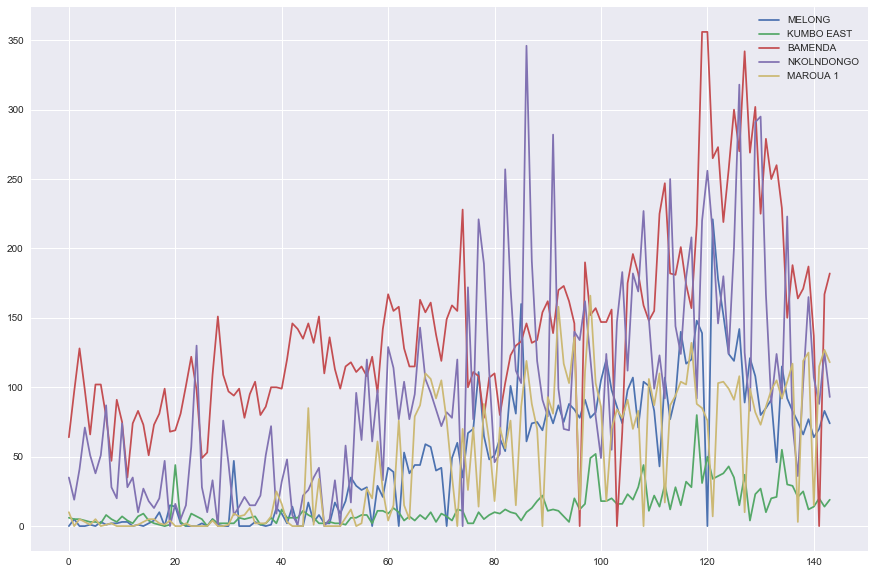

In [162]:
corrDf[['MELONG', 'KUMBO EAST', 'BAMENDA', 'NKOLNDONGO', 'MAROUA 1']].plot(figsize=(15, 10))

shapes
(100, 1, 10) (100, 1) (42, 1, 10) (42, 1)
training LSTM network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 1, 50)             12200     
_________________________________________________________________
dropout_43 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_44 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_22 (Activation)   (None, 1)                 0         
Total params: 72,701
Trainable params: 72,701
Non-trainable params: 0
_

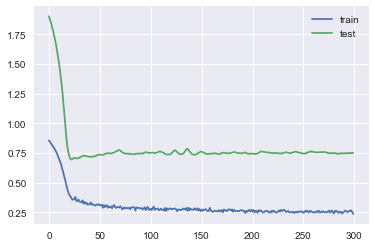

Root Mean Squared Error: 1545.904



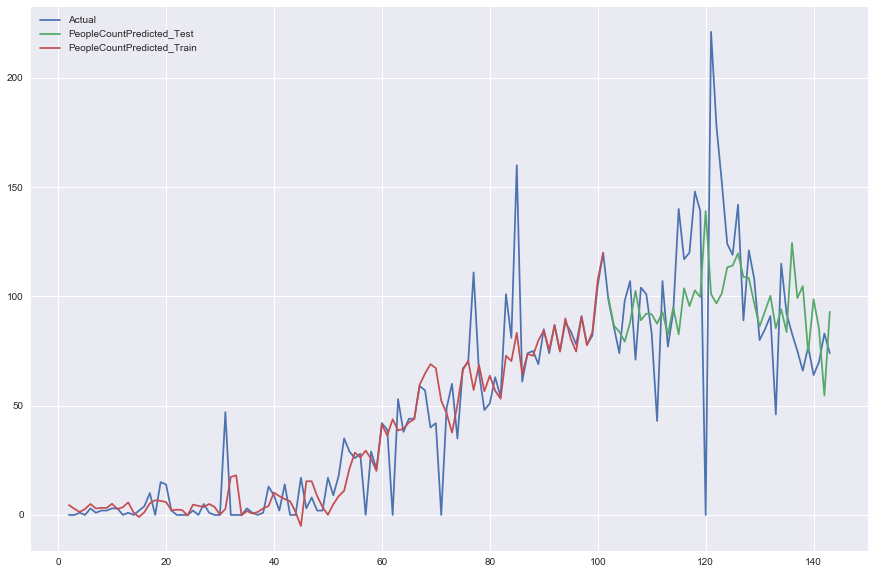

In [163]:
model(corrDf,'MELONG', ['KUMBO EAST', 'BAMENDA', 'NKOLNDONGO', 'MAROUA 1'], lookback=2,epochs=300)